In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.util as cutil
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter # type: ignore
from netCDF4 import Dataset
import h5netcdf
import matplotlib.animation as animation
import os
import glob
from datetime import datetime
from IPython.display import HTML

In [2]:
directory = "data/2024/27/"
data1 = directory + "Z__C_RJTD_etop_20240827060000.nc"
data2 = directory + "Z__C_RJTD_rain_20240827060000.nc"

e = xr.open_dataset(data1)
r = xr.open_dataset(data2)
etop = e["etop"]
rain = r["rain"]
etopKU = float(etop.sel(lat= 35.03, lon= 135.78, method='nearest'))
rainKU = float(rain.sel(lat= 35.03, lon= 135.78, method='nearest'))

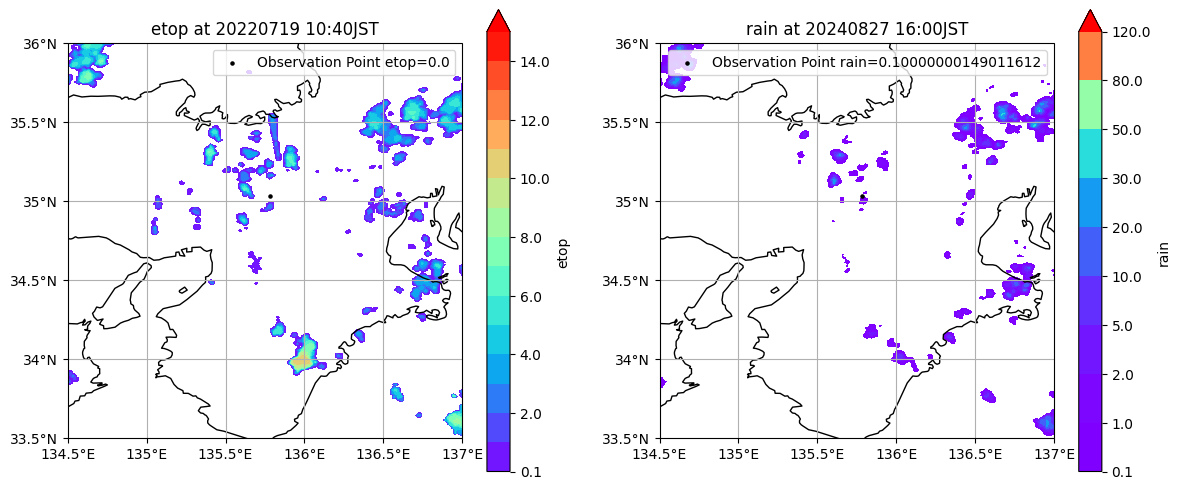

In [3]:
clevels1 = np.arange(1,15.1, 1) # 塗りつぶし用
clevels1 = np.append(0.1, clevels1)
clevels2 = np.array([0.1,1,2,5,10,20,30,50,80,120])
#clevels2 = np.arange(0.1,120)

# 描画
fig = plt.figure(figsize=(14,6))

# (1) 領域を用意（地図投影オプションをつけて）

# PlateCaree: 正距円筒図法, central_longitude: 図の中心の経度
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree(central_longitude=180))
ax2 = fig.add_subplot(122,projection=ccrs.PlateCarree(central_longitude=180))

# (2) 図を描く
lon_etop = etop.lon.values
lat_etop = etop.lat.values
etop_data = etop.values[0, :, :]
contour1 = ax1.contourf(lon_etop, lat_etop, etop_data, levels=clevels1, extend='max', cmap='rainbow', transform=ccrs.PlateCarree())
cb1 = plt.colorbar(contour1, ax=ax1, label='etop')

lon_rain = rain.lon.values
lat_rain = rain.lat.values
rain_data = rain.values[0, :, :]
contour2 = ax2.contourf(lon_rain, lat_rain, rain_data, levels=clevels2, extend='max', cmap='rainbow', transform=ccrs.PlateCarree())
cb2 = plt.colorbar(contour2, ax=ax2, label='rain')

# (4) 描画領域の設定
ax1.set_extent([134.5,137,33.5,36],crs=ccrs.PlateCarree())
ax2.set_extent([134.5,137,33.5,36],crs=ccrs.PlateCarree())

# (3) 目盛り（表示範囲に合わせて設定）
xticks = np.arange(134.5, 137.5, 0.5)  # 0.5度間隔
yticks = np.arange(33.5, 36.5, 0.5)    # 0.5度間隔
ax1.set_xticks(xticks, crs=ccrs.PlateCarree())
ax1.set_yticks(yticks, crs=ccrs.PlateCarree())
ax2.set_xticks(xticks, crs=ccrs.PlateCarree())
ax2.set_yticks(yticks, crs=ccrs.PlateCarree())
##　地図投影用の書式を設定（演習では無視（あるいはコピー）してもらって良い）
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
# 目盛りラベルを表示
ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)

# (5) オプション
ax1.coastlines() #海岸線
ax1.gridlines(draw_labels=False) #罫線：ラベルはすでに上で描いたので"False"
ax2.coastlines() #海岸線
ax2.gridlines(draw_labels=False)

KU_latitude = 35.03
KU_longitude = 135.78

# ax1（左側の図）に点を追加
ax1.scatter(KU_longitude, KU_latitude, color='black', s=5, transform=ccrs.PlateCarree(), label=f'Observation Point etop={etopKU}')

# ax2（右側の図）にも点を追加
ax2.scatter(KU_longitude, KU_latitude, color='black', s=5, transform=ccrs.PlateCarree(), label=f'Observation Point rain={rainKU}')
# 凡例を追加（オプション）
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

ax1.set_title('etop at 20220719 10:40JST')
ax2.set_title('rain at 20240827 16:00JST')

plt.show()

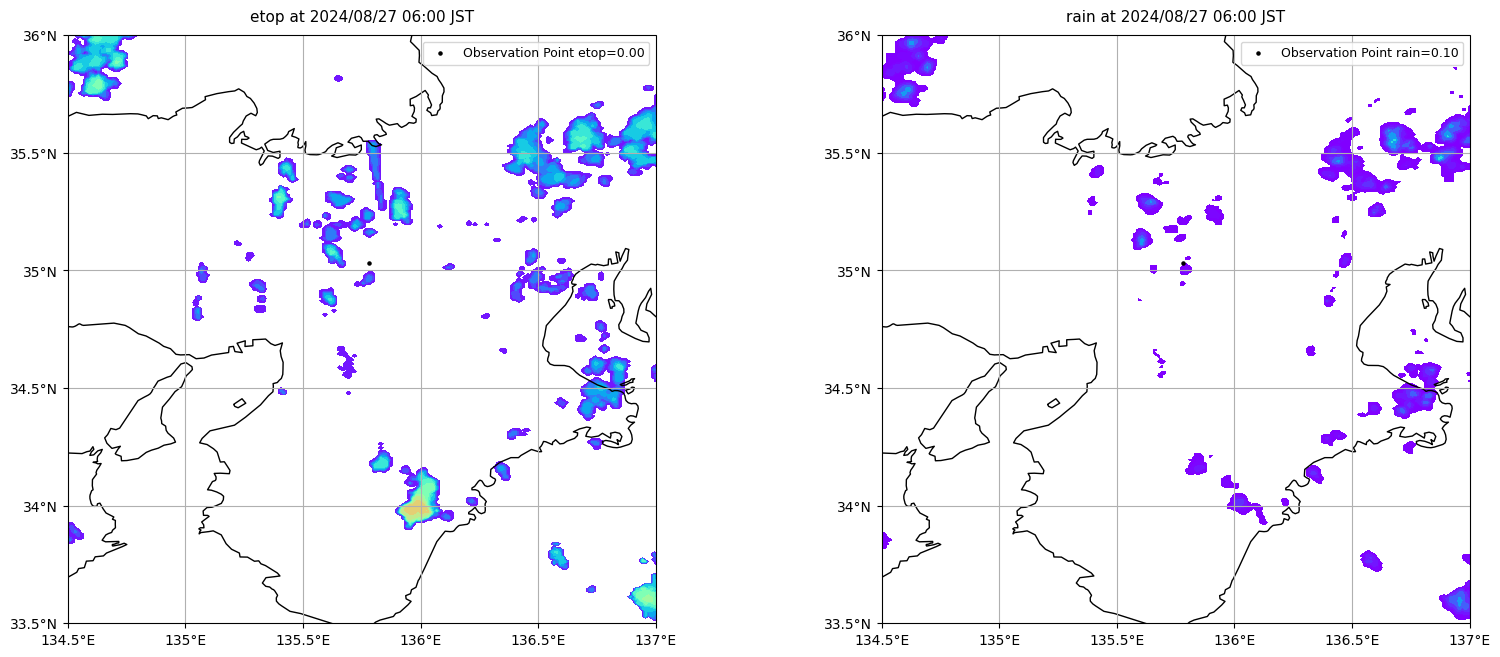

In [4]:
# ディレクトリ内のすべてのetopとrainファイルを取得
directory = "data/2024/27/"
etop_files = sorted(glob.glob(os.path.join(directory, "Z__C_RJTD_etop_*.nc")))
rain_files = sorted(glob.glob(os.path.join(directory, "Z__C_RJTD_rain_*.nc")))

# 観測地点の設定
KU_latitude = 35.03
KU_longitude = 135.78

# カラーレベルの設定
clevels1 = np.arange(1, 15.1, 1)  # etop用
clevels1 = np.append(0.1, clevels1)
clevels2 = np.array([0.1, 1, 2, 5, 10, 20, 30, 50, 80, 120])  # rain用

# アニメーション用の図を作成（サイズを大きくして余白を確保）
fig = plt.figure(figsize=(16, 7))
ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree(central_longitude=180))
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree(central_longitude=180))

def update_frame(frame_num):
    """各フレームを更新する関数"""
    ax1.clear()
    ax2.clear()
    
    etop_file = etop_files[frame_num]
    rain_file = rain_files[frame_num]
    
    # ファイル名から時刻を抽出
    filename = os.path.basename(etop_file)
    time_str = filename.split('_')[-1].replace('.nc', '')
    time_formatted = datetime.strptime(time_str, '%Y%m%d%H%M%S').strftime('%Y/%m/%d %H:%M JST')
    
    # データを読み込み
    e = xr.open_dataset(etop_file)
    r = xr.open_dataset(rain_file)
    etop = e["etop"]
    rain = r["rain"]
    
    # 観測地点の値を取得
    etopKU = float(etop.sel(lat=KU_latitude, lon=KU_longitude, method='nearest'))
    rainKU = float(rain.sel(lat=KU_latitude, lon=KU_longitude, method='nearest'))
    
    # 左側: etop
    lon_etop = etop.lon.values
    lat_etop = etop.lat.values
    etop_data = etop.values[0, :, :]
    contour1 = ax1.contourf(lon_etop, lat_etop, etop_data, levels=clevels1, 
                            extend='max', cmap='rainbow', transform=ccrs.PlateCarree())
    
    # 右側: rain
    lon_rain = rain.lon.values
    lat_rain = rain.lat.values
    rain_data = rain.values[0, :, :]
    contour2 = ax2.contourf(lon_rain, lat_rain, rain_data, levels=clevels2, 
                            extend='max', cmap='rainbow', transform=ccrs.PlateCarree())
    
    # 描画領域の設定
    ax1.set_extent([134.5, 137, 33.5, 36], crs=ccrs.PlateCarree())
    ax2.set_extent([134.5, 137, 33.5, 36], crs=ccrs.PlateCarree())
    
    # 目盛りの設定
    xticks = np.arange(134.5, 137.5, 0.5)
    yticks = np.arange(33.5, 36.5, 0.5)
    ax1.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax1.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax2.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax2.set_yticks(yticks, crs=ccrs.PlateCarree())
    
    # 地図投影用の書式を設定
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    ax1.tick_params(axis='both', which='major', labelsize=10)
    ax2.tick_params(axis='both', which='major', labelsize=10)
    
    # 海岸線と罫線
    ax1.coastlines()
    ax1.gridlines(draw_labels=False)
    ax2.coastlines()
    ax2.gridlines(draw_labels=False)
    
    # 観測地点を追加
    ax1.scatter(KU_longitude, KU_latitude, color='black', s=5, 
               transform=ccrs.PlateCarree(), 
               label=f'Observation Point etop={etopKU:.2f}')
    ax2.scatter(KU_longitude, KU_latitude, color='black', s=5, 
               transform=ccrs.PlateCarree(), 
               label=f'Observation Point rain={rainKU:.2f}')
    
    # 凡例とタイトル
    ax1.legend(loc='upper right', fontsize=9)
    ax2.legend(loc='upper right', fontsize=9)
    ax1.set_title(f'etop at {time_formatted}', fontsize=11, pad=10)
    ax2.set_title(f'rain at {time_formatted}', fontsize=11, pad=10)
    
    # データセットを閉じる
    e.close()
    r.close()
    
    return ax1, ax2

# アニメーションを作成（interval=500msで0.5秒ごとに更新）
anim = animation.FuncAnimation(fig, update_frame, frames=len(etop_files), 
                              interval=500, blit=False, repeat=True)

# レイアウトを調整（上下左右の余白を確保）
plt.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.08, wspace=0.3)

# アニメーションを表示
HTML(anim.to_jshtml())